### Lichess Game Analysis

Lets analyse the results of over 20000 chess games from Lichess games to see which factors influence the outcome of the result.

Lichess is a free and open-source Internet chess server run by a non-profit organization of the same name. Users of the site can play online chess anonymously and optionally register an account to play rated games. (Source - Wikipedia)

Data source - https://www.kaggle.com/datasets/datasnaek/chess

Tools used - Jupyter Notebook, Python, NumPy, Pandas, Matplotlib, Seaborn

##### Setting up work environment

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [30]:
data = pd.read_csv('games.csv')

In [31]:
plt.style.use('seaborn-v0_8-dark')
cust_colors = ['#fdc029',
'#f7c14c',
'#f0c268',
'#e8c381',
'#dfc498',
'#d4c5af',
'#c6c6c6',
'#a6a6a8',
'#86868a',
'#68686d',
'#4b4c52',
'#303138',
'#171820', '#171820', '#171820', '#171820']
plt.rcParams['figure.figsize'] = (24,10)

##### 1. Analyzing player ratings

Lets first analyse player ratings uing the 'white_rating' & 'black_rating' columns to create and average and then seperate them into brackets. 

In [32]:
data['avg_rating'] = (data['white_rating'] + data['black_rating']) / 2

In [33]:
data[['white_rating','black_rating','avg_rating']]

,white_rating,black_rating,avg_rating
0,1500,1191,1345.5
1,1322,1261,1291.5
2,1496,1500,1498.0
3,1439,1454,1446.5
4,1523,1469,1496.0
...,...,...,...
20053,1691,1220,1455.5
20054,1233,1196,1214.5
20055,1219,1286,1252.5
20056,1360,1227,1293.5


Lets determine the min and max of the average to determine how big our brackets need to be. 

In [34]:
data['avg_rating'].min()

816.5

In [35]:
data['avg_rating'].max()

2475.5

In [36]:
bracket_edges = list(range(800,2600,100))
bracket_labels = [f'{start}-{end-1}' for start, end in zip(bracket_edges[:-1], bracket_edges[1:])]

data['avg_rating_bracket'] = pd.cut(data['avg_rating'], bins=bracket_edges, labels=bracket_labels)

Great, now that we've determing average player ratings and created brackets for each match to be placed into, lets merge anything with a rating below 1000 into a single bracket and anything above 2330 into a single bracket to make it slightly easier to work with. 

In [61]:
data["avg_rating_bracket"].replace("800-899", "900-1000", inplace = True)
data["avg_rating_bracket"].replace("900-1000", "- 1000", inplace = True)
data["avg_rating_bracket"].replace("2400-2499", "2300-2400", inplace = True)
data["avg_rating_bracket"].replace("2300-2400", "2300 +", inplace = True)
data["avg_rating_bracket"].replace("2300-2399", "2300 +", inplace = True)
data["avg_rating_bracket"].replace("- 1000", "1000 -", inplace = True)
data["avg_rating_bracket"].replace("900-999", "1000 -", inplace = True)

In [62]:
data['avg_rating_bracket'].value_counts()

avg_rating_bracket
1500-1599    3073
1400-1499    3008
1600-1699    2525
1300-1399    2290
1700-1799    2141
1800-1899    1770
1200-1299    1392
1900-1999    1193
1100-1199     789
2000-2099     784
2100-2199     439
1000-1099     291
2200-2299     187
1000 -         93
2300 +         83
Name: count, dtype: int64

Great, lets visualise this now to get a better look at our brackets. 

C:\Users\brayd\AppData\Local\Temp\ipykernel_25700\3833298422.py:1: UserWarning: The palette list has more values (16) than needed (15), which may not be intended.
  sns.barplot(x = data["avg_rating_bracket"].value_counts().index, y=data["avg_rating_bracket"].value_counts().values,


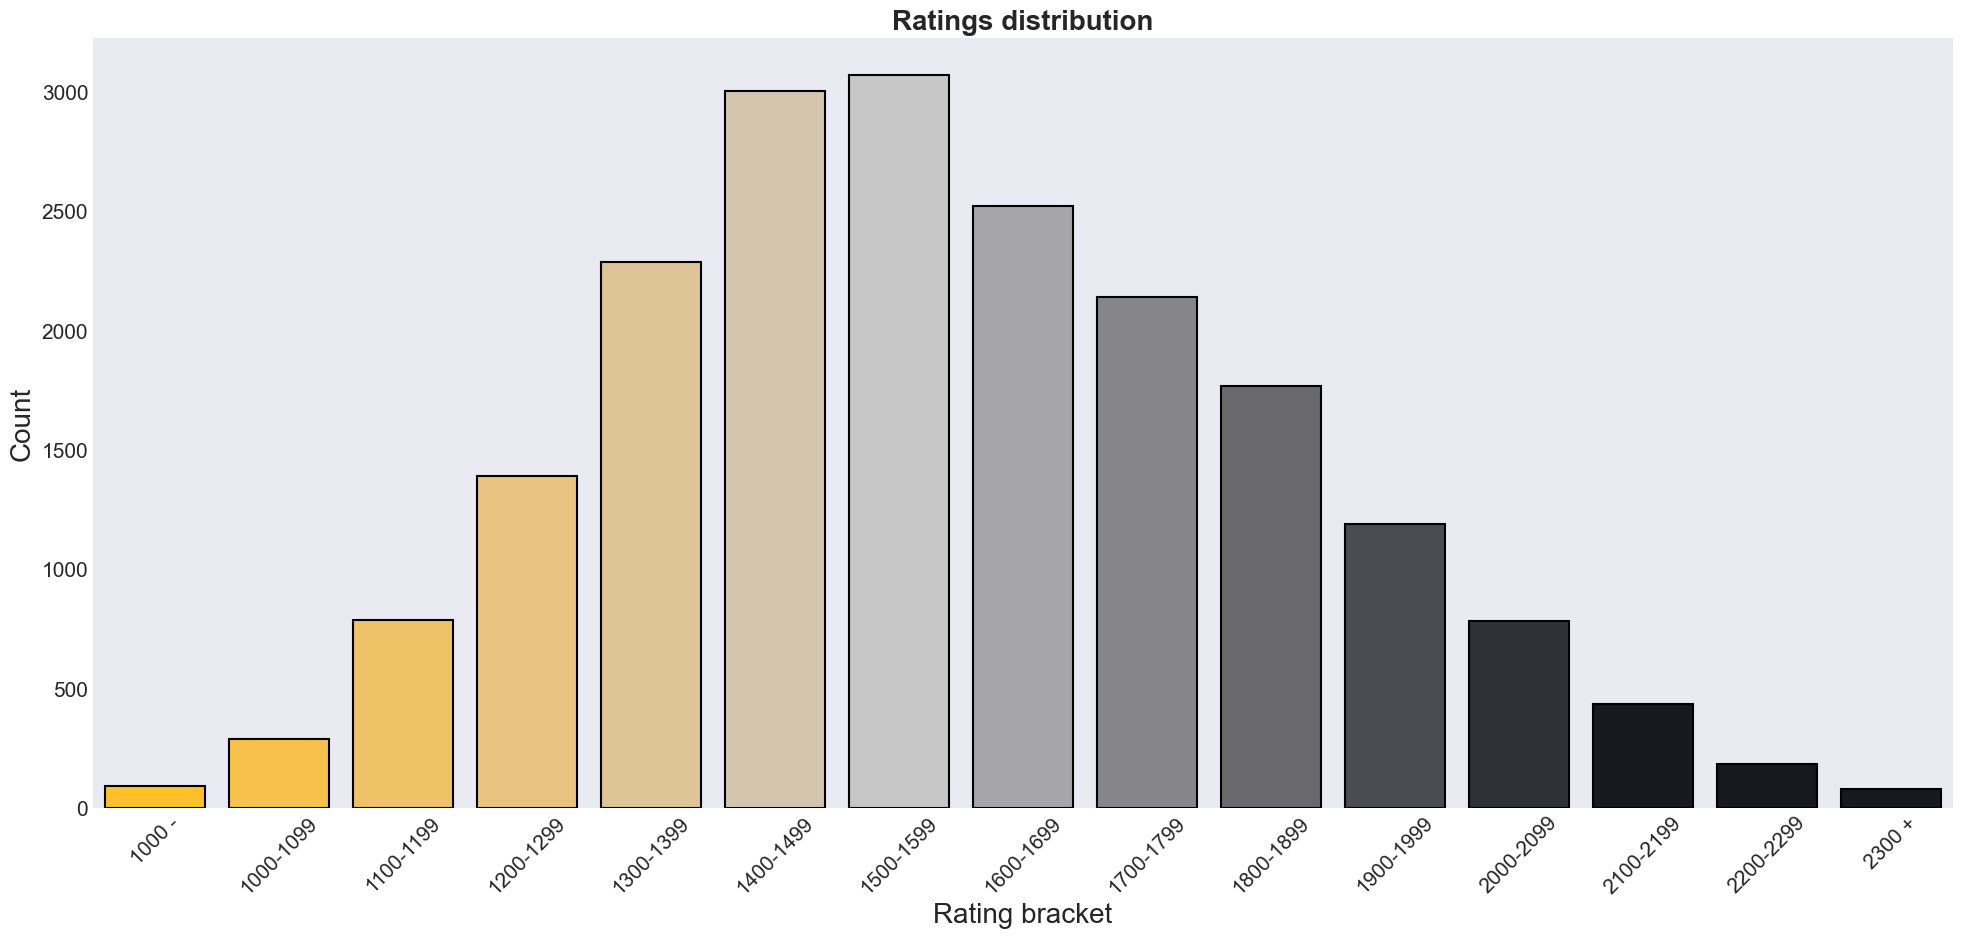

In [63]:
sns.barplot(x = data["avg_rating_bracket"].value_counts().index, y=data["avg_rating_bracket"].value_counts().values,  
            palette=cust_colors, edgecolor='black', linewidth=1.5, 
            saturation=1.5, hue = data["avg_rating_bracket"].value_counts().index, 
            legend=False, order = sorted(set(data["avg_rating_bracket"])))

plt.title('Ratings distribution', weight='bold', fontsize=20)
plt.xlabel("Rating bracket", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.xticks(fontsize=15, rotation = 45)
plt.yticks(fontsize=15)
plt.show()

As we can see in the above barchart, we're looking at a pretty standard bell curve distribution. 
This indicates that the majority of plays fall into the midrange of the rating scale of chess (ELO rating). 

##### 2. Analysing the relationship between rating and moves taken in a game. 

Now, lets take a look at moves made per game and see how that is affected by the rating of the player.

C:\Users\brayd\AppData\Local\Temp\ipykernel_25700\1886156882.py:1: UserWarning: The palette list has more values (16) than needed (15), which may not be intended.
  plots = sns.barplot(x = data.groupby("avg_rating_bracket", observed=False)["turns"].mean().index,


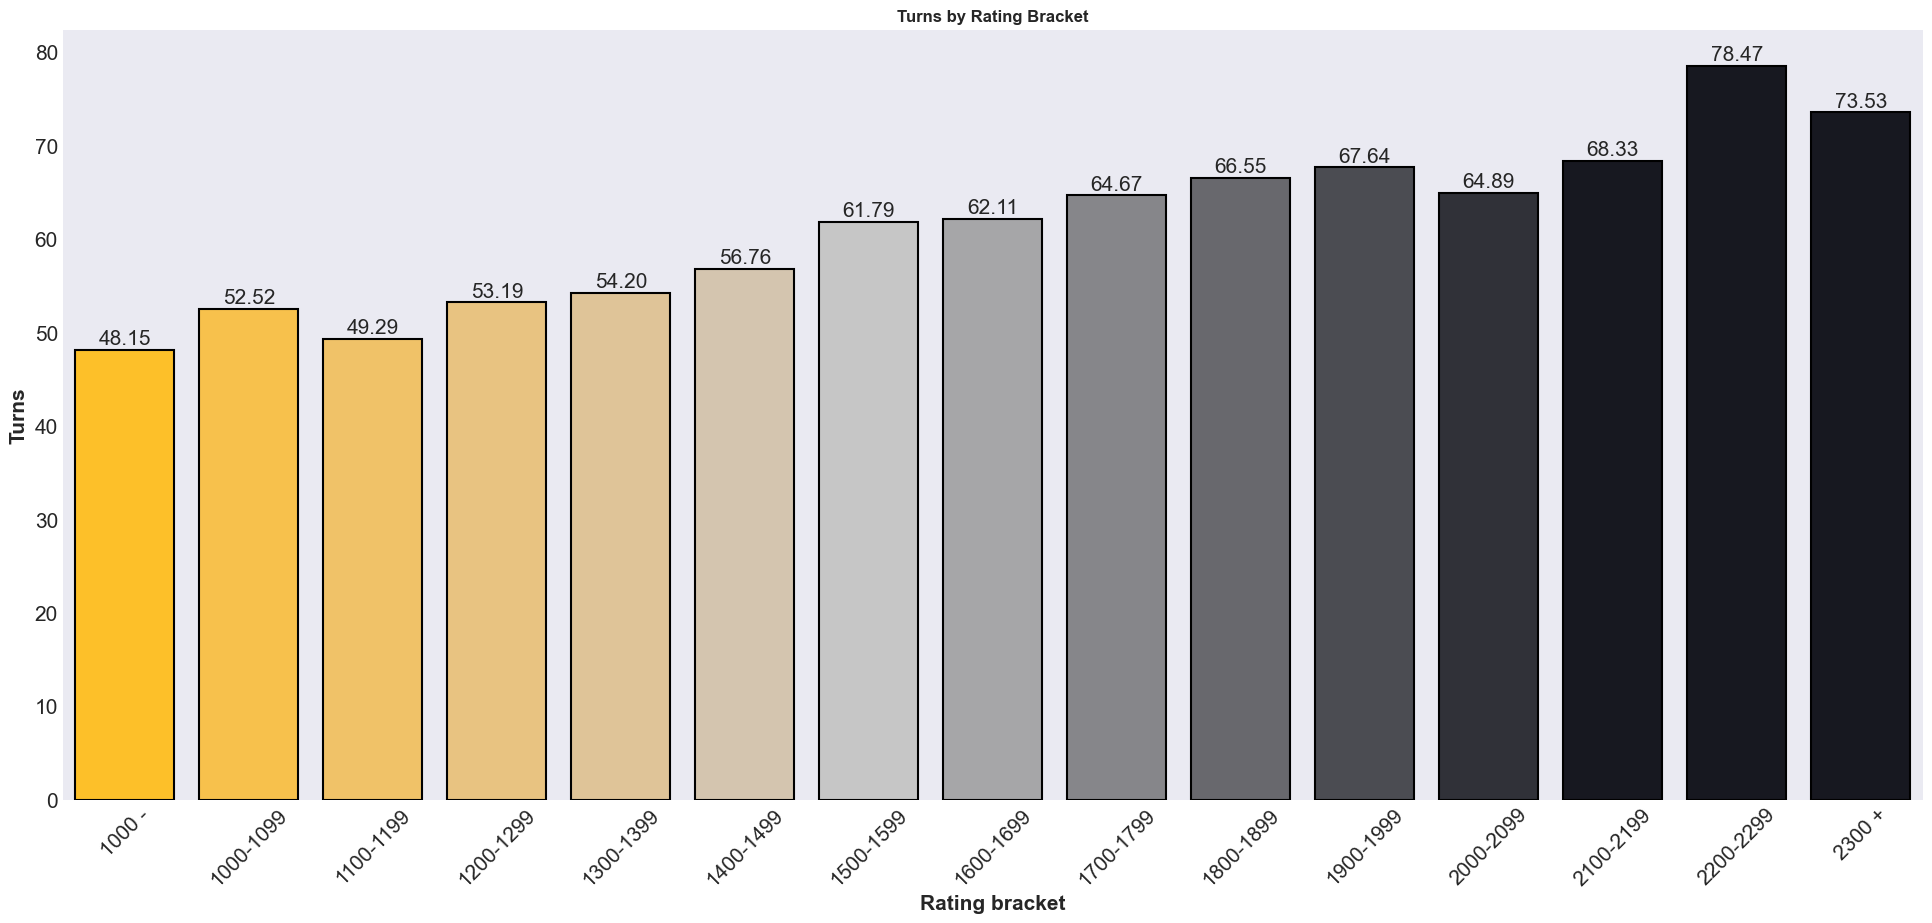

In [64]:
plots = sns.barplot(x = data.groupby("avg_rating_bracket", observed=False)["turns"].mean().index,
            y=data.groupby("avg_rating_bracket", observed=False)["turns"].mean(),  
            palette=cust_colors, edgecolor='black', linewidth=1.5, saturation=1.5, 
            hue= data.groupby("avg_rating_bracket", observed=False)["turns"].mean().index,legend=False)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.title('Turns by Rating Bracket', weight='bold')
plt.xlabel("Rating bracket", weight='semibold',fontsize=15)
plt.ylabel("Turns", weight='semibold',fontsize=15)
plt.xticks(fontsize=15, rotation = 45)
plt.yticks(fontsize=15)
plt.show()

From the above barchart, we can see that as rating bracket increases so does the number of turns per match. This tells us that as the rating of the games rises so does the complexity of the matches resulting in more turns being made to reach the end of the match. 

##### 3. Opening Moves by Rating. 

Let's dig into the opening moves of each match and see if there are any interesting trends relating to ranking and choice of opener. 

In [66]:
len(data['opening_name'].value_counts())

122

As we can see there are 1477 opening moves across just over 20000 matches. Lets see if there is anything we can do to clean this up and make it easier to analyse.

In [67]:
opening_moves = set(data['opening_name'])
for i in opening_moves:
    print(i)

# results hidden for readability 

Amar Opening
Queen's Pawn
Clemenz Opening
Gruenfeld Defense
Creepy Crawly Formation
Scotch Gambit
Hungarian Opening
Blackmar-Diemer Gambit
Colle System
Petrov's Defense
King's Indian Attack
Hippopotamus Defense
Czech Defense
Scandinavian Defense
Scotch Game
Tarrasch Defense
Danish Gambit
Australian Defense
Pterodactyl Defense
Queen's Gambit
Barnes Opening
Wade Defense
Gedult's Opening
Old Benoni Defense
Goldsmith Defense
Carr Defense
Mieses Opening
Kangaroo Defense
Center Game
Ponziani Opening
Modern Defense
Crab Opening
Slav Indian
Vienna Game
King's Knight Opening
Zukertort Opening
Benoni Defense
Nimzowitsch Defense
Catalan Opening
Nimzo-Larsen Attack
Mikenas Defense
Latvian Gambit
Petrov
Benko Gambit
Old Indian
Elephant Gambit
Caro-Kann Defense
Horwitz Defense
Pirc Defense
Van Geet Opening
King's Gambit
Reti Opening
Indian Game
Ruy Lopez
Alekhine Defense
Mexican Defense
Grob Opening
English Opening
Queen's Indian Accelerated
Russian Game
Amazon Attack
Neo-Gruenfeld Defense
Italian G

We can see that there are a lot of reoccuring results with delimiters specifying variations of the of the opening move. Let's clean this up by splitting of parts of the string which occur after the delimiters used. This will clean up our results and make what we're looking at a lot cleaner

In [68]:
data["opening_name"] = data["opening_name"].apply(lambda x: x.split(":")[0])
data["opening_name"] = data["opening_name"].apply(lambda x: x.split(" |")[0])
data["opening_name"] = data["opening_name"].apply(lambda x: x.split(" #")[0])
data["opening_name"] = data["opening_name"].apply(lambda x: x.split(" Accepted")[0])
data["opening_name"] = data["opening_name"].apply(lambda x: x.split(" Declined")[0])
data["opening_name"] = data["opening_name"].apply(lambda x: x.split(" Refused")[0])

data["opening_name"].replace("King's Pawn Game", "King's Pawn", inplace = True)
data["opening_name"].replace("King's Pawn Opening", "King's Pawn", inplace = True)
data["opening_name"].replace("Old Indian Defense", "Old Indian", inplace = True)
data["opening_name"].replace("Queen's Pawn Game", "Queen's Pawn", inplace = True)
data["opening_name"].replace("Queen's Pawn Opening", "Queen's Pawn", inplace = True)
data["opening_name"].replace("Ware Defense", "Ware Opening", inplace = True)

In [69]:
len(data['opening_name'].value_counts())

122

In [70]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

data['opening_name'].value_counts()
# results hidden for readability 

opening_name
Sicilian Defense              2632
French Defense                1412
Queen's Pawn                  1376
Italian Game                   981
King's Pawn                    948
Queen's Gambit                 912
Ruy Lopez                      858
English Opening                720
Scandinavian Defense           716
Philidor Defense               691
Caro-Kann Defense              597
Scotch Game                    465
Four Knights Game              370
Van't Kruijs Opening           368
Zukertort Opening              336
Bishop's Opening               323
Indian Game                    319
Pirc Defense                   288
Russian Game                   252
Slav Defense                   240
King's Gambit                  237
Modern Defense                 225
Nimzowitsch Defense            224
Horwitz Defense                209
King's Indian Defense          197
Alekhine Defense               192
King's Knight Opening          183
Hungarian Opening              179
Center 

Great! That's cleaned things up nicely. Now we have 122 opening moves to look at, however most of them are below 100 uses.

Let's create a new data frame with all the opening moves above 100. 

In [71]:
data2 = data.groupby('opening_name').filter(lambda x: len(x)>100)

In [72]:
print(data.shape)
print(data2.shape)

(20058, 18)
(17969, 18)


In [73]:
print(len(data['opening_name'].value_counts()))
print(len(data2['opening_name'].value_counts()))

122
39


As we can see, with our new dataframe we're left with 39 opening moves. These make up for 89.58% of all matches. 

Now let's create a heatmap to show the distrubtion of the opening moves across each rating bracket

<function matplotlib.pyplot.show(close=None, block=None)>

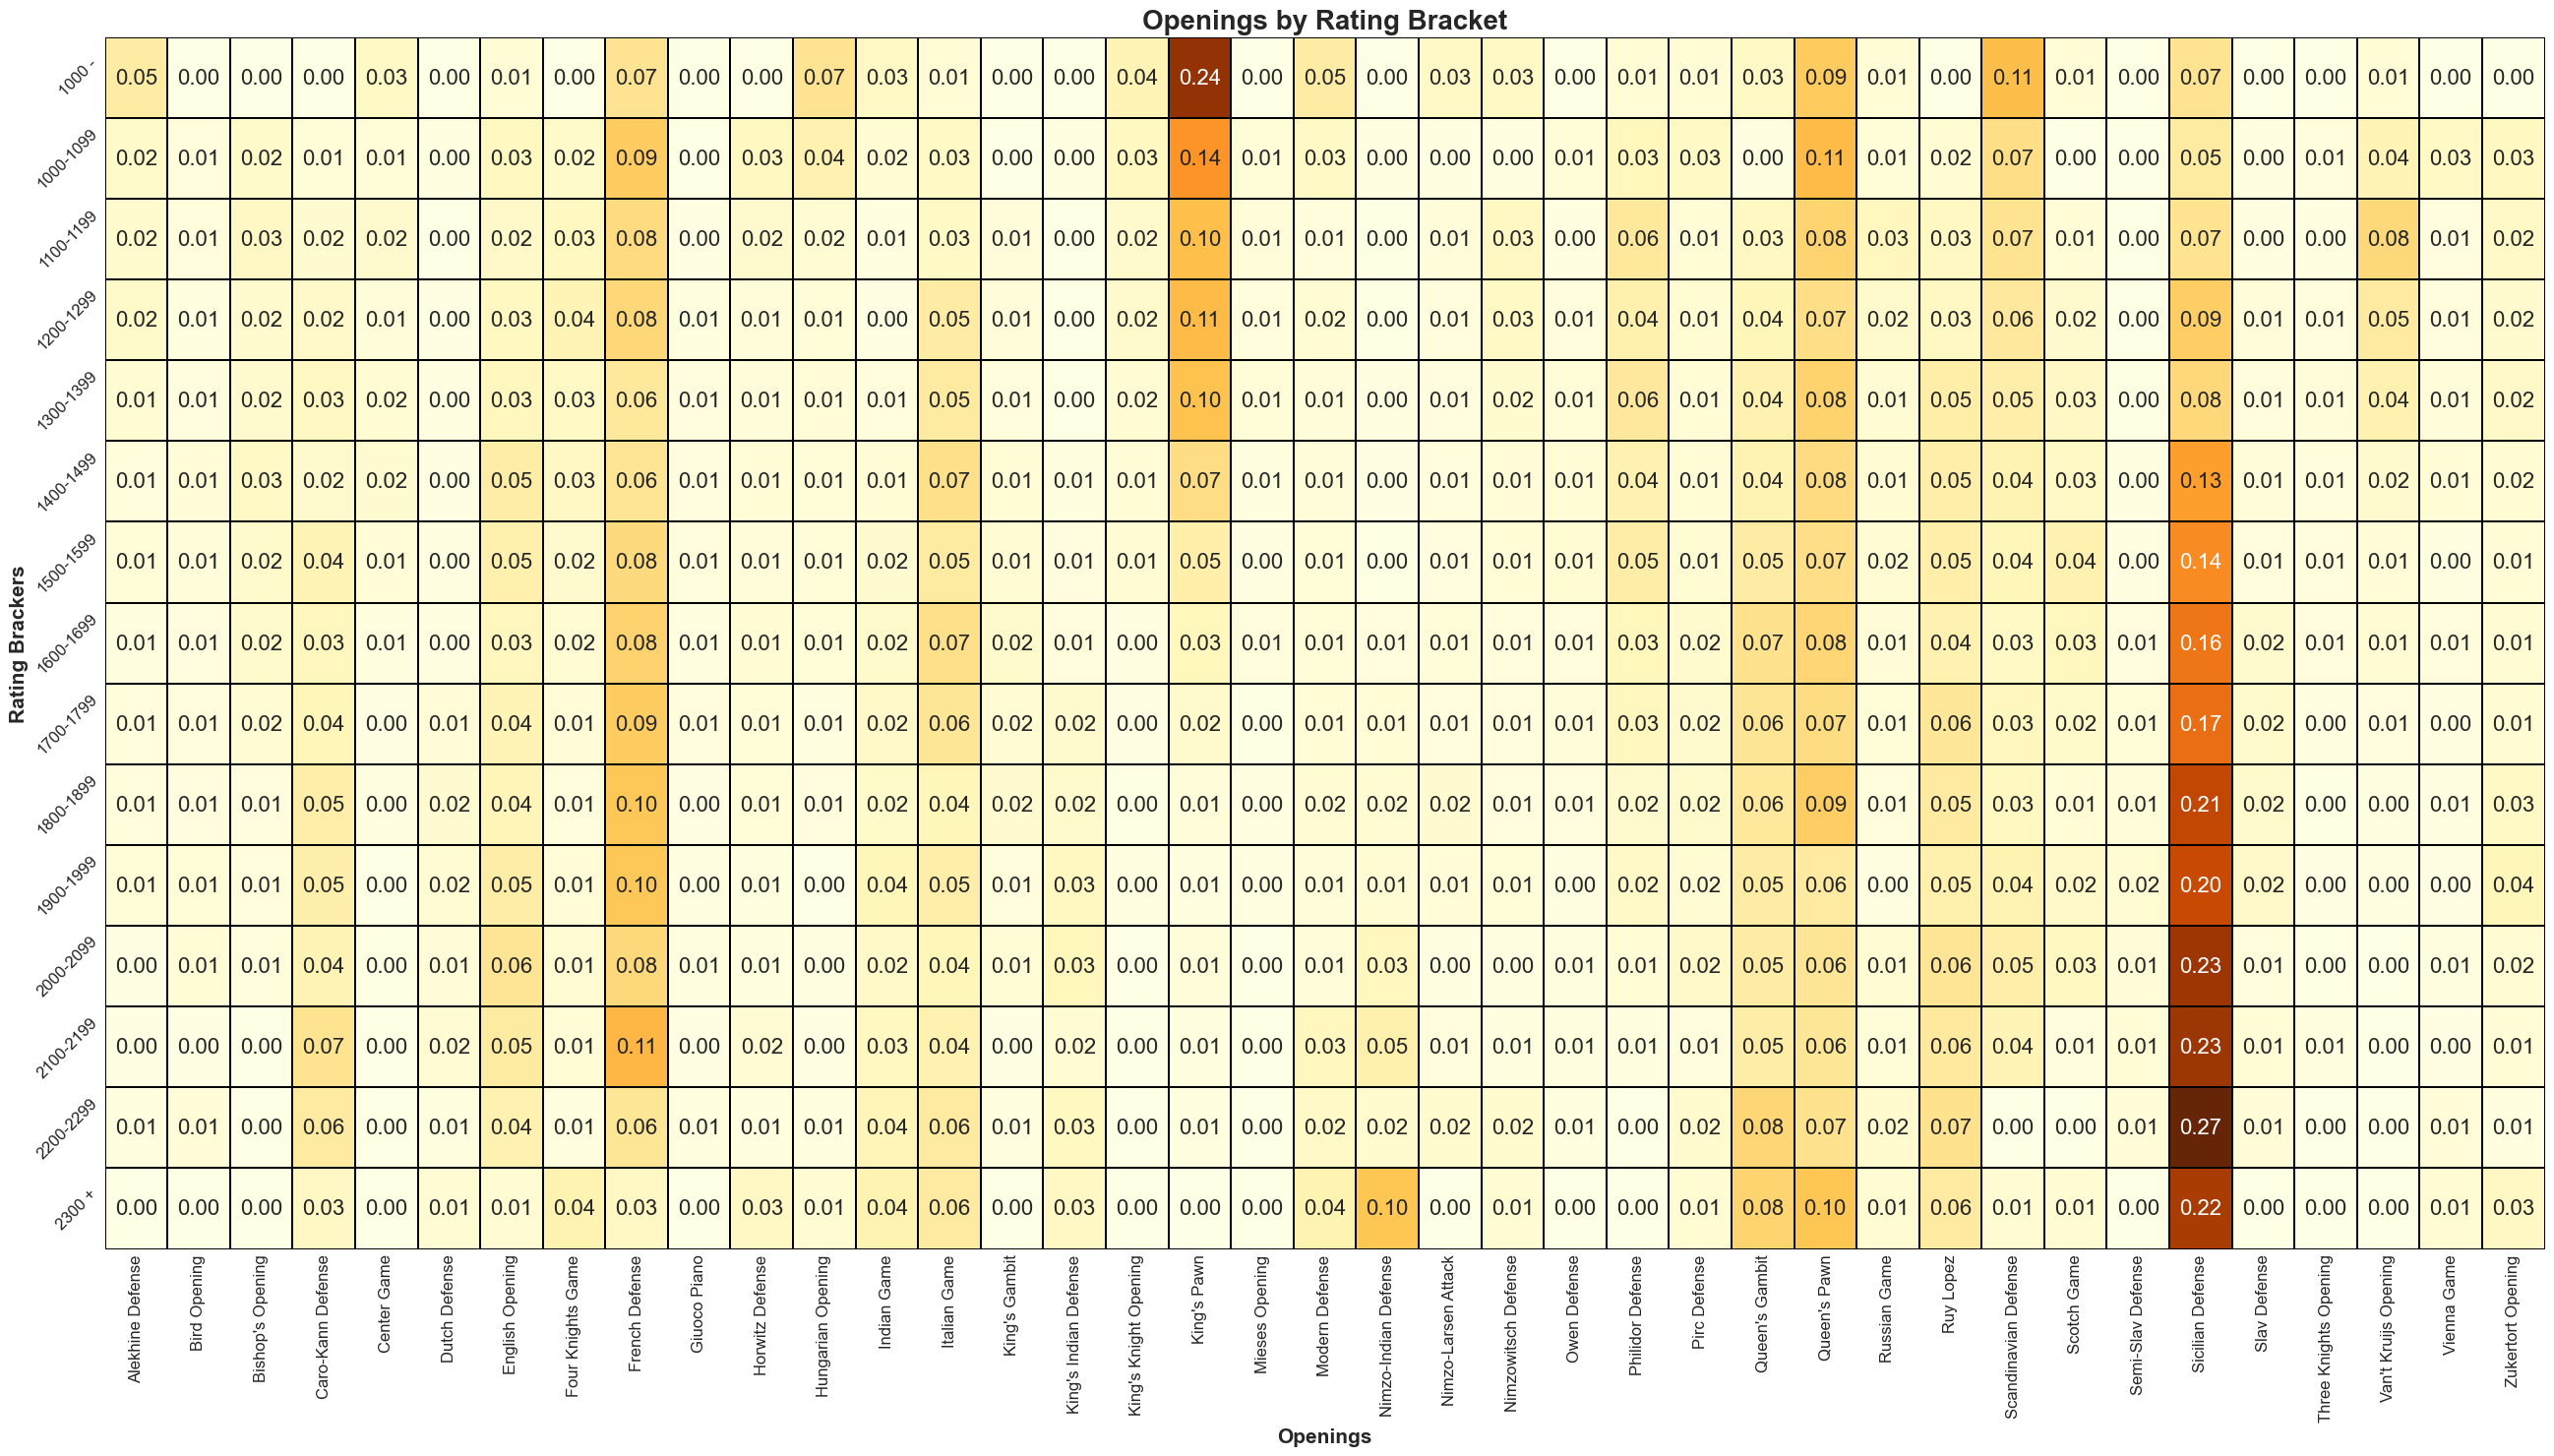

In [74]:
z = data2.groupby(['avg_rating_bracket', 'opening_name'], observed=False).size().unstack().fillna(0).astype(int)

fig, ax = plt.subplots(figsize=(32,16))

sns.heatmap(z.apply(lambda x: x/x.sum(), axis=1), xticklabels=True, yticklabels=True,
           cmap='YlOrBr', annot=True, linewidths=0.005, linecolor='black', annot_kws={"fontsize":16},
           fmt= '.2f', cbar=False)

plt.title('Openings by Rating Bracket', weight= 'bold', fontsize = 20)
plt.xticks(fontsize = 12)
plt.xlabel('Openings', weight= 'semibold', fontsize = 15)
plt.yticks(fontsize = 12, rotation = 45)
plt.ylabel('Rating Brackers', weight = 'semibold', fontsize = 15)
plt.show

As we can see from our heat map showing the normalised values of opening occurences we can see a couple of moves that stand out;

- Sicillian Defense - 
As players make their way through the ranks, they're far more likely to see this opening move used or use it themselves. 
- Kings Pawn - 
And as players make their way through the ranks they're far LESS likely to see the Kings Pawn opening move used. 

##### 4. Match Outcome by Rating

In chess, white moves first. Let's see if this has any significant effect on the outcome of matches.

In [75]:
data3 = data.groupby(['avg_rating_bracket', 'winner'], observed=False).size().unstack().astype(int) 
data3 = data3.div(data3.sum(axis=1), axis=0).mul(100).round(2)

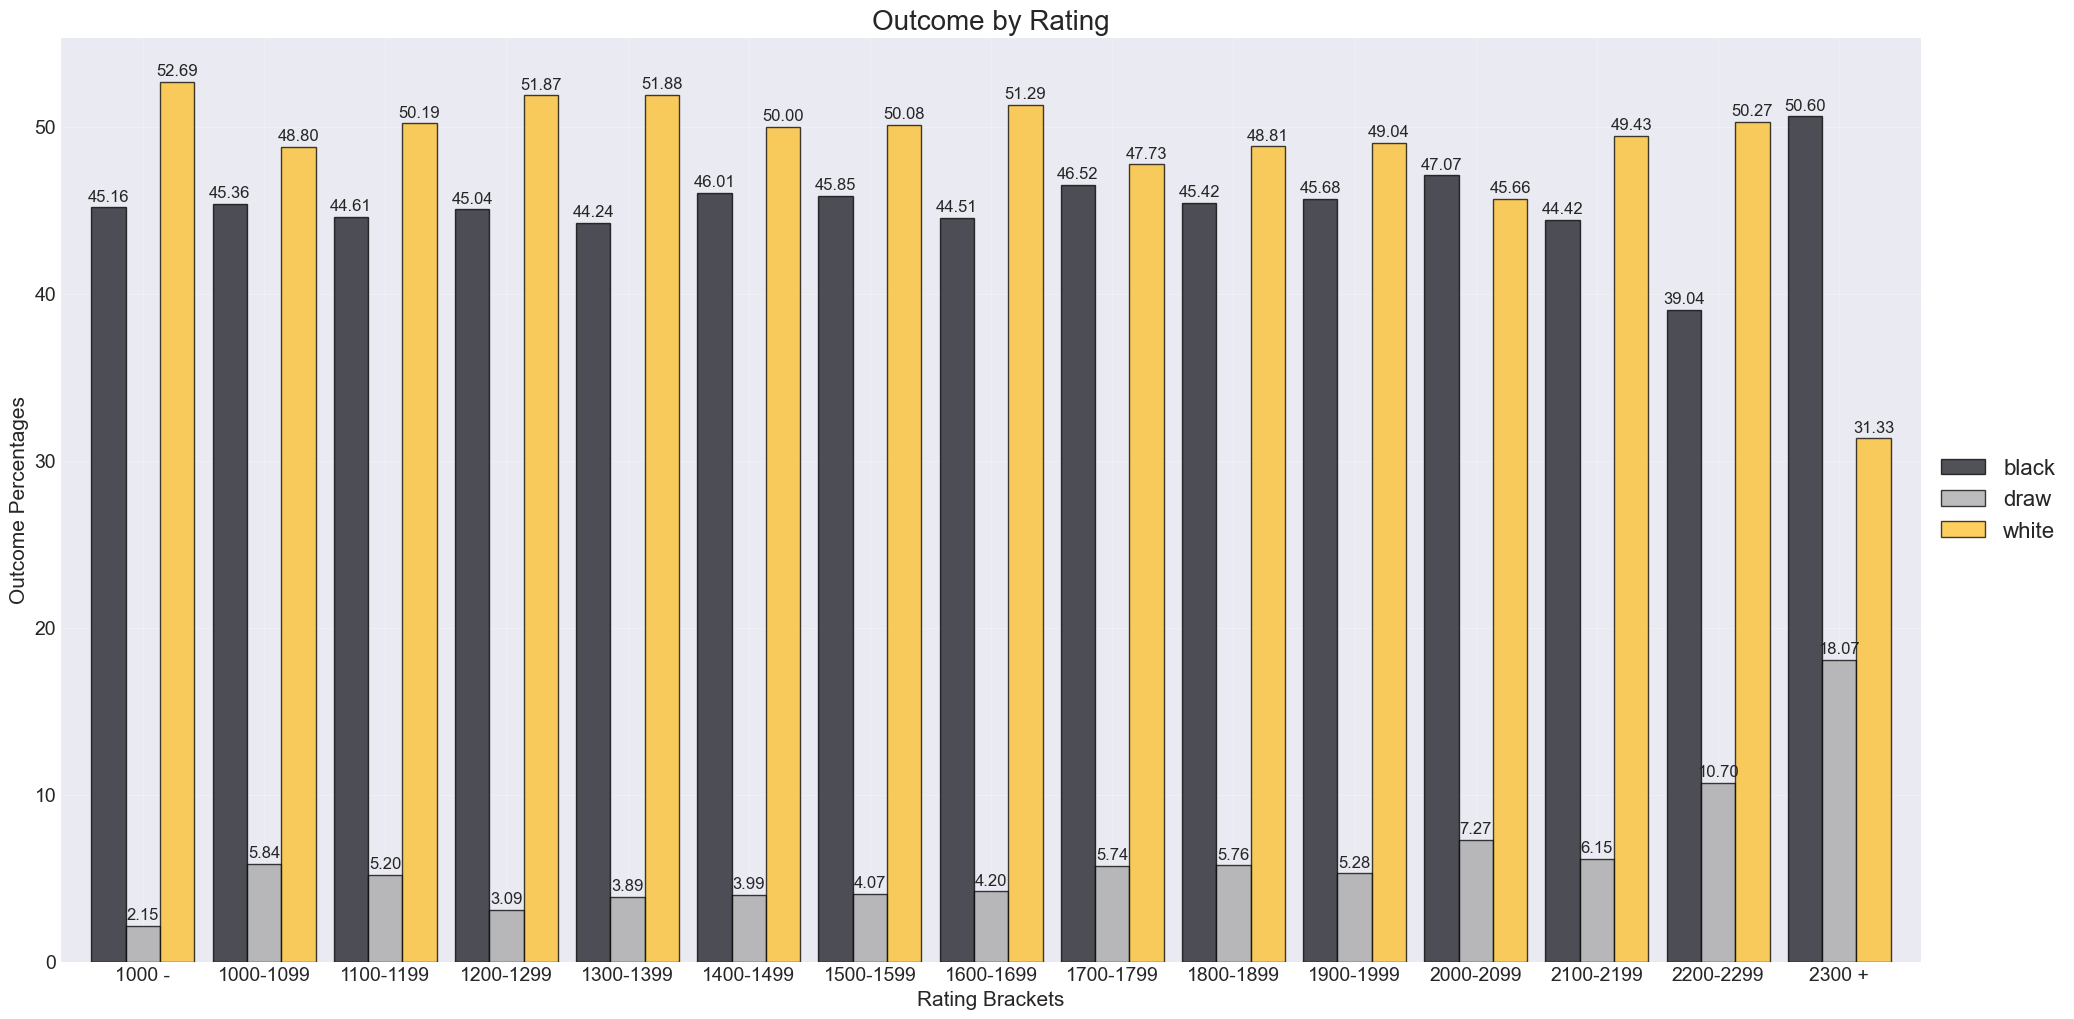

In [86]:
plots = data3.plot(kind= 'bar', alpha= 0.75, color = ['#171820', '#a6a6a8', '#fdc029'], 
                  figsize = (24,12), width = 0.85, edgecolor= 'black')

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=12, xytext=(0, 8),
                   textcoords='offset points')
plots.grid(alpha = 0.25)
plots.set_title('Outcome by Rating', fontsize=20)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), prop={'size':16})
plt.xlabel('Rating Brackets', fontsize= 15)
plt.xticks(fontsize= 14, rotation= 0)
plt.ylabel('Outcome Percentages', fontsize = 15)
plt.yticks(fontsize=14)
plt.show()
           

- As we can see in the above chart, it appears that white has a slight advantage over black as far as match outcome.
- The only time this differs is in the 2300 + bracket where black edges out white, this is also the smallest bracket so some bias may apply here. 
- We can also see as the brackets move up, the chance of a draw gradually increases.

##### 5. Opening Victors

Let's dig deeper into the opening moves and sort them by how many turns their respective games took. 

In [88]:
data2.groupby('opening_name')['turns'].mean().nlargest(39)

opening_name
King's Indian Defense    70.756345
Semi-Slav Defense        69.518519
Nimzo-Indian Defense     66.662420
Indian Game              65.673981
Modern Defense           65.320000
Caro-Kann Defense        64.613065
Slav Defense             64.183333
Queen's Pawn             63.502180
Ruy Lopez                63.393939
Hungarian Opening        63.212291
Nimzo-Larsen Attack      63.176829
Philidor Defense         63.037627
English Opening          62.840278
Sicilian Defense         62.786094
Queen's Gambit           62.348684
Vienna Game              61.868613
Four Knights Game        61.545946
French Defense           61.223796
Dutch Defense            60.720000
Pirc Defense             59.791667
Three Knights Opening    59.538462
Horwitz Defense          58.722488
Zukertort Opening        58.446429
Alekhine Defense         58.359375
Giuoco Piano             58.194444
Owen Defense             57.754386
Italian Game             57.477064
Nimzowitsch Defense      56.995536
King's 

Let's now create a new dataframe that compares each opening's outcomes. We'll also sort this by how many turns they last. 

In [89]:
data2.groupby('opening_name')['turns'].mean().nlargest(39).index

Index(['King's Indian Defense', 'Semi-Slav Defense', 'Nimzo-Indian Defense',
       'Indian Game', 'Modern Defense', 'Caro-Kann Defense', 'Slav Defense',
       'Queen's Pawn', 'Ruy Lopez', 'Hungarian Opening', 'Nimzo-Larsen Attack',
       'Philidor Defense', 'English Opening', 'Sicilian Defense',
       'Queen's Gambit', 'Vienna Game', 'Four Knights Game', 'French Defense',
       'Dutch Defense', 'Pirc Defense', 'Three Knights Opening',
       'Horwitz Defense', 'Zukertort Opening', 'Alekhine Defense',
       'Giuoco Piano', 'Owen Defense', 'Italian Game', 'Nimzowitsch Defense',
       'King's Gambit', 'Scandinavian Defense', 'Scotch Game',
       'Bishop's Opening', 'Van't Kruijs Opening', 'Russian Game',
       'Bird Opening', 'Center Game', 'King's Pawn', 'King's Knight Opening',
       'Mieses Opening'],
      dtype='object', name='opening_name')

In [92]:
data3 = data2.groupby(['winner','opening_name']).size().unstack().fillna(0).astype(int)
data3 = data3.div(data3.sum(axis=0), axis=1).mul(100).round(2).transpose()
data3 = data3.reindex(["King's Indian Defense", "Semi-Slav Defense", "Nimzo-Indian Defense", "Indian Game",
                       "Modern Defense", "Caro-Kann Defense", "Slav Defense", "Queen's Pawn", "Ruy Lopez",
                       "Hungarian Opening", "Nimzo-Larsen Attack", "Philidor Defense", "English Opening",
                       "Sicilian Defense", "Queen's Gambit", "Vienna Game", "Four Knights Game", "French Defense", 
                       "Dutch Defense", "Pirc Defense", "Three Knights Opening", "Horwitz Defense", "Zukertort Opening",
                       "Alekhine Defense", "Giuoco Piano", "Owen Defense", "Italian Game", "Nimzowitsch Defense",
                       "King's Gambit", "Scandinavian Defense", "Scotch Game", "Bishop's Opening", "Van't Kruijs Opening",
                       "Russian Game", "Bird Opening", "Center Game", "King's Pawn", "King's Knight Opening", "Mieses Opening"])

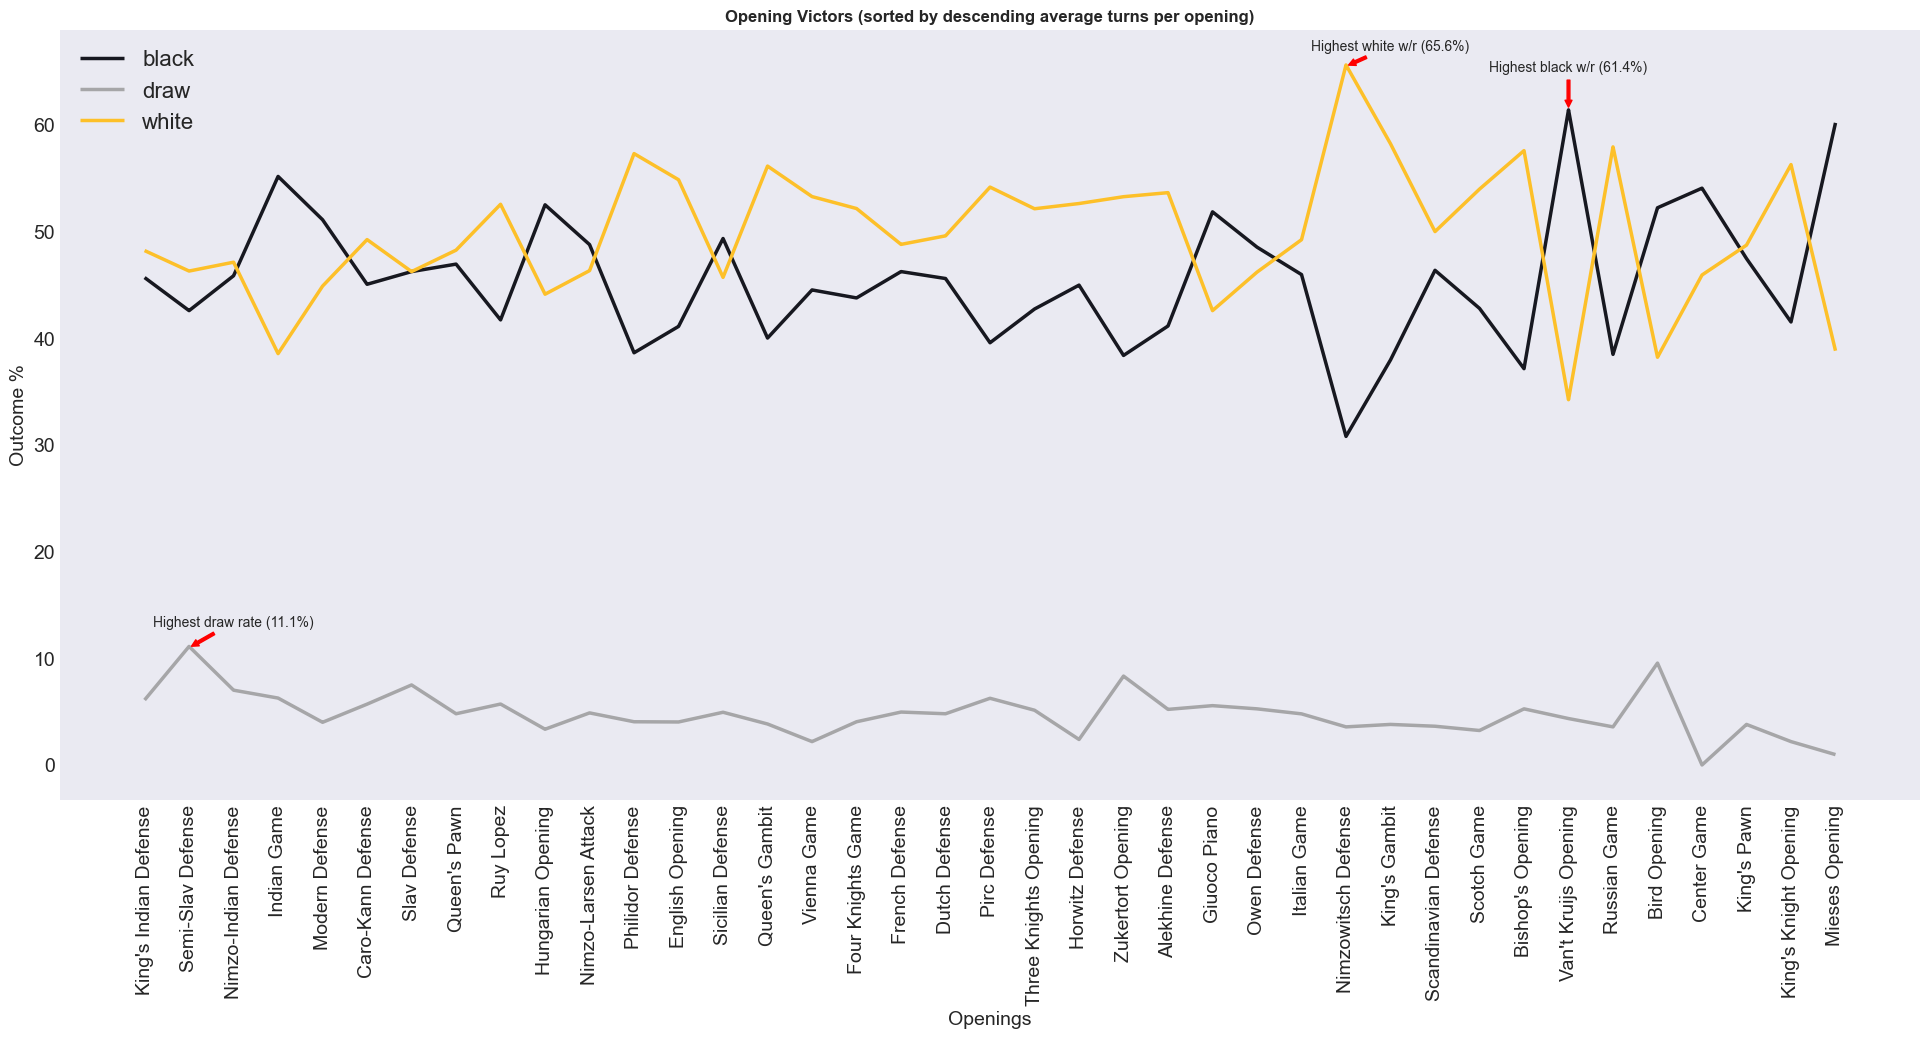

In [111]:
fig, ax = plt.subplots(figsize=(24,10))

sns.lineplot(data= data3, palette=['#171820', '#a6a6a8', '#fdc029'], dashes=[(1,0),(1,0),(1,0)],
            sort=False, linewidth=2.5)

plt.annotate("Highest draw rate (11.1%)", xy=(1,11), xytext=(2,13), horizontalalignment="center",
             arrowprops=dict(arrowstyle='simple',lw=1, color='red') )
plt.annotate("Highest white w/r (65.6%)", xy=(27,65.5), xytext=(28,67), horizontalalignment="center",
             arrowprops=dict(arrowstyle='simple',lw=1, color='red') )
plt.annotate("Highest black w/r (61.4%)", xy=(32,61.4), xytext=(32,65), horizontalalignment="center",
             arrowprops=dict(arrowstyle='simple',lw=1, color='red') )

plt.title('Opening Victors (sorted by descending average turns per opening)',
         weight='bold')
plt.legend(prop={'size':16})
plt.xlabel('Openings', fontsize=14)
plt.xticks(fontsize= 14, rotation = 90)
plt.ylabel("Outcome %", fontsize=14)
plt.yticks(fontsize= 14)
plt.show()


- In this chart, the openings are represented on the x-axis and are sorted by how many turns on average their respective games last in descending order. With this in mind, we can see that there is no vissible correlation between a games outcome and its duration in turns.

- 11 of the 39 openings favor the 'black' player. 2 of them have a winrate of 60% + (Van't Kruijs Opening - 61.41% and Mieses Opening - 60.19%).
- The overall highest winrate of 65.62% belongs to Nimzowitsch's defense used by 'white' players, beating second place by a significant margin (Russian Game's 57.94%).
- Finally the highest draw rate goes to the Semi-Slav Defense sitting at 11.11% chance of ending in a draw.

##### 6. Opening Outcomes

Finally let's look into the victory status parameter. 

In [98]:
data2['victory_status'].value_counts()

victory_status
resign       10007
mate          5654
outoftime     1504
draw           804
Name: count, dtype: int64

As we can see above, over half of all the matches end in a resignation. This isn't unexpected, if a player is being overwhelmed by their opponent or they have external responsibilties to attend to they will end the match prematurely. 

Now we can see if this is the case with the openings, we'll create a similar plot to the previous one but we'll change out the player color distribution for outcome types.

In [106]:
data4 = data2.groupby(['victory_status','opening_name']).size().unstack().fillna(0).astype(int)
data4 = data4.div(data4.sum(axis=0), axis=1).mul(100).round(2).transpose()
data4 = data4.reindex(["King's Indian Defense", "Semi-Slav Defense", "Nimzo-Indian Defense", "Indian Game",
                       "Modern Defense", "Caro-Kann Defense", "Slav Defense", "Queen's Pawn", "Ruy Lopez",
                       "Hungarian Opening", "Nimzo-Larsen Attack", "Philidor Defense", "English Opening",
                       "Sicilian Defense", "Queen's Gambit", "Vienna Game", "Four Knights Game", "French Defense", 
                       "Dutch Defense", "Pirc Defense", "Three Knights Opening", "Horwitz Defense", "Zukertort Opening",
                       "Alekhine Defense", "Giuoco Piano", "Owen Defense", "Italian Game", "Nimzowitsch Defense",
                       "King's Gambit", "Scandinavian Defense", "Scotch Game", "Bishop's Opening", "Van't Kruijs Opening",
                       "Russian Game", "Bird Opening", "Center Game", "King's Pawn", "King's Knight Opening", "Mieses Opening"])

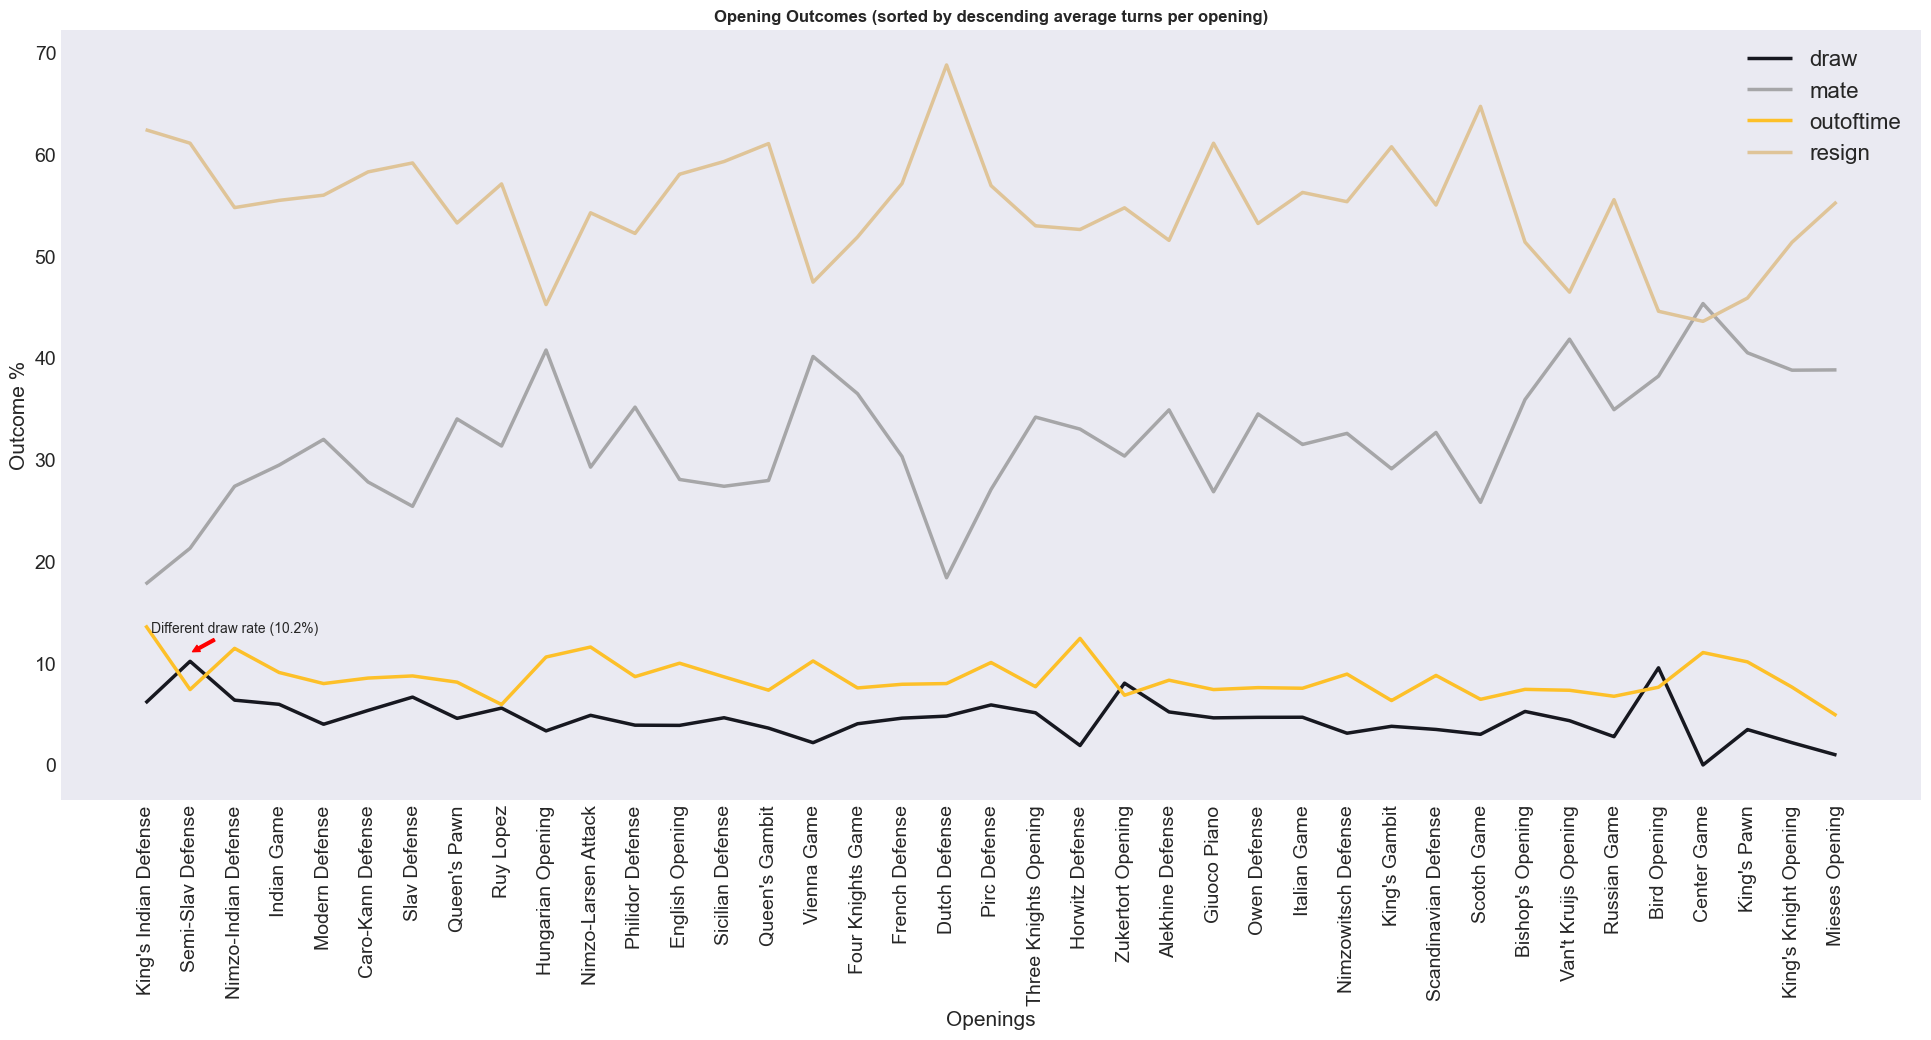

In [112]:
fig, ax = plt.subplots(figsize=(24,10))

sns.lineplot(data= data4, palette=['#171820', '#a6a6a8', '#fdc029','#dfc498'], dashes=[(1,0),(1,0),(1,0),(1,0)],
            sort=False, linewidth=2.5)

plt.annotate("Different draw rate (10.2%)", xy=(1,11), xytext=(2,13), horizontalalignment="center",
             arrowprops=dict(arrowstyle='simple',lw=1, color='red') )

plt.title('Opening Outcomes (sorted by descending average turns per opening)',
         weight='bold')
plt.legend(prop={'size':16})
plt.xlabel('Openings', fontsize=15)
plt.xticks(fontsize= 14, rotation = 90)
plt.ylabel("Outcome %", fontsize=15)
plt.yticks(fontsize= 14)
plt.show()


At a glance, it seems that the outcomes follow a pattern; resignations are most frequent, followed by mates, then out of time games and finally draws. But a closer look at the draw line and we can see a discrepancy in the Semi-Slav Defense point, it has a 1% lower occurence here than in the previous plot. Lets investigate what may be causing this.

In [114]:
data2[(data2['winner'] == 'draw') & (data2['victory_status'] != 'draw')]
len(data2[(data2['winner'] == 'draw') & (data2['victory_status'] != 'draw')])

42

Based on the above, we can see there are 42 instancces of a draw occuring where a player ran out of time. An explanation for this from googles states that "In online chess, if your opponent has insufficient mating material when you run out of time, the game is scored as a draw"

- Of all the openings, only one has higher mate than resign rate. (Center Game)
- There are 3 occurences of an opening having a higher 'draw' than 'out-of-time' rate; the Semi-Slav Defense, Zukertort Opening and the Bird Opening.